#microRNAs Functional Clustering 

microRNAs are small non-coding molecules produced by the genome to regulate its activity. These small ribo-nucleic acids (RNA) molecules are 22-24 nucleotids long and can recognize, by base-pairing (A binds U, C binds G), complementary sequences on messengers RNAs (mRNA). The consequences of the binding of a microRNA (miR) on its complementary targets' sequences (on various mRNAs) is an inhibition of mRNAs translation into proteins, such as cellular enzymes.
    
Accordingly to the [mirbase database](ftp://mirbase.org/pub/mirbase/CURRENT/README), 35,828 microRNAs from 223 species were sequenced. For exemple, the human genome encodes 2,588 miRs and the mouse genome 1,915 miRs. Here I will use the most up-to-date [TargetScan](http://www.targetscan.org/cgi-bin/targetscan/data_download.cgi?db=vert_70) database which has recently improved its target scoring algorithm to include up to 14 distinctive features [Agarwal et al. 2015](http://elifesciences.org/content/4/e05005).

Despite the progresses made for the prediction of microRNA targets, the functions of the microRNAs are still poorly understood. While most studies address the biological function of individual microRNAs, it is anticipated from the highly connected network of miRs-mRNAs interactions that microRNAs cooperate for the regulation of the cell's transcriptome (the ensemble of expressed mRNAs). 

**Could we define some functional clusters of microRNAs accordingly to their common targets?**

##1. The TargetScan database

I will use the `Conserved_Site_Context_Scores.txt` file from TargetScan to build a graph database in Neo4j.

In [2]:
import pandas as pd
database = pd.read_csv("C:/Users/mgirardot/Desktop/neo4j/Conserved_Site_Context_Scores.txt", sep="\t")
database.head()

,Gene ID,Gene Symbol,Transcript ID,Gene Tax ID,miRNA,Site Type,UTR_start,UTR end,context++ score,context++ score percentile,weighted context++ score,weighted context++ score percentile
0,ENSG00000121410.7,A1BG,ENST00000263100.3,9544,mml-miR-23a-3p,3,142,149,-0.428,97,-0.388,97
1,ENSG00000121410.7,A1BG,ENST00000263100.3,9544,mml-miR-23b-3p,3,142,149,-0.428,97,-0.388,97
2,ENSG00000121410.7,A1BG,ENST00000263100.3,9598,ptr-miR-23b,3,143,150,-0.419,97,-0.419,98
3,ENSG00000121410.7,A1BG,ENST00000263100.3,9598,ptr-miR-23a,3,143,150,-0.419,97,-0.419,98
4,ENSG00000121410.7,A1BG,ENST00000263100.3,9598,ptr-miR-23c,3,143,150,-0.419,97,-0.419,98


This is a database of genes (`Gene ID; Gene Symbol`) and transcripts (`Transcript ID`) for each species (`Gene Tax ID`). microRNAs predicted to bind these transcripts are reported in the `miRNA` column with its `type`(**1** : 7mer-1a(seed match 2-7+A); **2** : 7mer-m8 (seed match 2-8); **3** : 8mer (seed match 2-8+A); **4** : 6mer(seed match 2-7)), and binding position on the transcript (`UTR_start , UTR end`).

Context++ score stands for a linear regression model of 14 features [Agarwal 2015](http://lens.elifesciences.org/05005/index.html): 
- TA_3UTR (3' UTR target abundance in all annotated 3'UTR [0.222]), 
- TA_ORF (ORF target site abundance in all ORF ), 
- SPS (predicted seed-pairing stability $\Delta$G° [0.210]),
- sRNA1 | 8 (identity of nucleotide at position 1 | 8 of the miR [-0.018:0.06]), 
- site1|8|9|10 (identity of nucleotide at position 1|8|9|10 of the target ), 
- local_AU (AU content near the site [-0.254]), 
- 3P_score (supplementary pairing at 3' miRNA [-0.04]),
- SA (structural accessibility as Log10 probability that a 14nt segment centered on the match to miRNA pos 7-8 is unpaired [-0.115]),
- min_stop (log10 distance from stop codon [0.118]),
- len_ORF (log10 length of ORF [0.205]),
- len_3UTR ( log10 length 3'UTR [0.310]),
- off6m ( Number of offset 6mer sites in the 3'UTR [-0.02]),
- ORF8m ( Number of 8mer sites in the ORF [-0118]),
- Pct (Probability of conserved targetting [-0.103])

Weighted context++ score take into account the relative abundance of alternative 3'UTRs targeted by the microRNA.

In [6]:
# What is the number of genes?
nb_genes = len(database.groupby(by="Gene Symbol"))
print("Number of genes: %d" % nb_genes)

Number of genes: 13522


In [8]:
# What is the number of microRNAs in Human (ID:9606)?
nb_hsa_mir = len(database[database["Gene Tax ID"] == 9606].groupby(by="miRNA"))
print("Number of Human microRNA: %d" % nb_hsa_mir)

Number of Human microRNA: 401


In [9]:
#What is the number of microRNAs in mouse (ID:10090)?
nb_mmu_mir = len(database[database["Gene Tax ID"] == 10090].groupby(by="miRNA"))
print("Number of mouse microRNAs: %d" % nb_mmu_mir)

Number of mouse microRNAs: 399


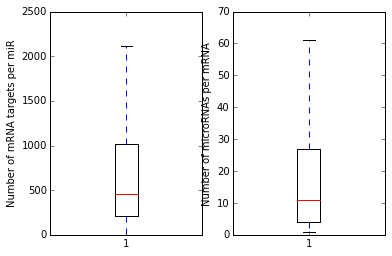

In [220]:
%matplotlib inline
import matplotlib.pyplot as plt

#How many targets per miR in human?
hsa_database = database[database["Gene Tax ID"] == 9606]
gene_per_mir = hsa_database.groupby(by="miRNA").count()

#How many miR per gene in human?
mir_per_gene = hsa_database.groupby(by="Gene Symbol").count()

plt.subplot(1,2,1)
plt.boxplot(gene_per_mir["Gene Symbol"], patch_artist=True, showfliers=False)
plt.ylabel("Number of mRNA targets per miR")

plt.subplot(1,2,2)
plt.boxplot(mir_per_gene["miRNA"], patch_artist=True, showfliers=False)
plt.ylabel("Number of microRNAs per mRNA")
plt.show()

There is about 500 targets per microRNA and each mRNA is recognized by about 10 microRNAs.

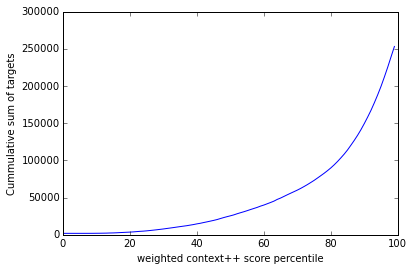

In [18]:
import numpy as np
score_grp = hsa_database.groupby(by="weighted context++ score percentile").count()
plt.plot(score_grp.index, np.cumsum(score_grp["Gene ID"]), '-', color='b')
plt.ylabel("Cummulative sum of targets")
plt.xlabel("weighted context++ score percentile")
plt.show()

The majority of microRNA affects mRNA regulation by a 60 to 100% score. It means that very few predictions of interactions will have a negligible effect individualy. However these weak regulators can still affect mRNA regulation when acting cooperatively.

##2. Building a graph database of microRNAs-mRNA interactions

The network of microRNAs-mRNAs interactions are best represented as graph. Here I will use the [Neo4j](http://neo4j.com/) graph database. I am running a local instance of a Neo4j server. The REST API can be accessed with the [`py2neo`](http://py2neo.org/2.0/intro.html) client library. 

In [19]:
from py2neo import Graph, authenticate, Relationship
#Read the password for the local database
f = open("C:/Users/mgirardot/Desktop/neo4j/pass_neo4j.txt",'r')
passwd = f.read()
f.close()

#create an instance of Graph bound to the http://localhost:7474/db/data
graph=Graph()
authenticate("localhost:7474","neo4j",passwd)

 

In [20]:
#Constructing the graph
for i,row in hsa_database.iterrows():
    rna = graph.merge_one("RNA","NAME", row["Gene Symbol"])
    mir = graph.merge_one("MIR","NAME", row["miRNA"])
    graph.create_unique(Relationship(mir, "TARGET", rna, score=row["weighted context++ score percentile"]))

In [21]:
#Use the cypher language to interrogate the graph database
graph.cypher.execute('''
    MATCH (mir :MIR)-[r:TARGET]->(rna : RNA)
    WITH COUNT(DISTINCT mir) AS Number_of_miRs,
         COUNT(DISTINCT r) AS Number_of_Relationships,
         COUNT(DISTINCT rna) AS Number_of_mRNAs
    RETURN Number_of_miRs, Number_of_Relationships, Number_of_mRNAs;
''')

   | Number_of_miRs | Number_of_Relationships | Number_of_mRNAs
---+----------------+-------------------------+-----------------
 1 |            401 |                  250340 |           12424

In this project I am interested in the frequency of co-occurence of microRNA on targets to group them into functional clusters. I will then add a node feature to the `:MIR` to store the number of target of each miR.

In [22]:
graph.cypher.execute('''
    MATCH (m:MIR)-[r:TARGET]->(:RNA)
    WITH m, COUNT(DISTINCT r) AS nb_tar
    SET m.NB_TARGETS = nb_tar;
''')

In [25]:
#Example of node enriched with a new feature
graph.cypher.execute('''
    MATCH (m:MIR {NAME: "hsa-miR-28-5p"})
    RETURN m;
''')

   | m                                               
---+--------------------------------------------------
 1 | (n156:MIR {NAME:"hsa-miR-28-5p",NB_TARGETS:240})

##3. Defining a distance mesurement between microRNAs

Clustering methods are using a common metric such as euclidian distance between data points to group them accordingly. The metric to use here is the frequency of common targets between a pair of miR. The similarity of miRs based on their common targets is a Jaccard coefficient:
$$ J(A,B) = \frac{|A \cap B|}{|A \cup B|}$$
Thus the Jaccard distance is:
$$ J_{\delta} = 1 - J(A,B)$$

The intersection of miR-A and miR-B is the number of common targets and the union is the total number of targets of miR-A and miR-B without their common targets.


In [33]:
#compute the Jaccard distance for each pair of miRs and create a new relationship
from py2neo.packages.httpstream import http
http.socket_timeout = 9999   # fix for the socket timeout error

graph.cypher.execute('''
    MATCH (mir1:MIR)-[r1:TARGET]->(n:RNA)<-[r2:TARGET]-(mir2:MIR)
    WITH mir1, mir2,tofloat(mir1.NB_TARGETS) AS mir1_tar,tofloat(mir2.NB_TARGETS) AS mir2_tar, tofloat(COUNT(DISTINCT n)) AS nb_tar
    WHERE mir1.NAME <> mir2.NAME
    WITH mir1,mir2,(1-nb_tar/(mir1_tar + mir2_tar - nb_tar)) AS Jaccard
    CREATE UNIQUE (mir1)-[:DISTANCE {JACCARD:Jaccard}]-(mir2);
''')

In [40]:
#Select a subgraph for testing purposes
ex_mir=["hsa-miR-23a-3p","hsa-miR-23b-3p","hsa-miR-23c","hsa-miR-6838-5p","hsa-miR-16-5p","hsa-miR-195-5p","hsa-miR-15a-5p","hsa-miR-15b-5p","hsa-miR-424-5p","hsa-miR-497-5p","hsa-miR-130a-5p"]

graph.cypher.execute('''
    WITH {N} AS coll
    MATCH (mir1:MIR)
    WHERE mir1.NAME IN coll
    SET mir1.SUBGRAPH ="YES"
    RETURN mir1
''', {"N":ex_mir})

    | mir1                                                             
----+-------------------------------------------------------------------
  1 | (n1:MIR {NAME:"hsa-miR-130a-5p",NB_TARGETS:1531,SUBGRAPH:"YES"}) 
  2 | (n2:MIR {NAME:"hsa-miR-23a-3p",NB_TARGETS:1540,SUBGRAPH:"YES"})  
  3 | (n3:MIR {NAME:"hsa-miR-23b-3p",NB_TARGETS:1543,SUBGRAPH:"YES"})  
  4 | (n4:MIR {NAME:"hsa-miR-23c",NB_TARGETS:1539,SUBGRAPH:"YES"})     
  5 | (n17:MIR {NAME:"hsa-miR-424-5p",NB_TARGETS:1864,SUBGRAPH:"YES"}) 
  6 | (n18:MIR {NAME:"hsa-miR-15a-5p",NB_TARGETS:1875,SUBGRAPH:"YES"}) 
  7 | (n19:MIR {NAME:"hsa-miR-497-5p",NB_TARGETS:1876,SUBGRAPH:"YES"}) 
  8 | (n20:MIR {NAME:"hsa-miR-16-5p",NB_TARGETS:1882,SUBGRAPH:"YES"})  
  9 | (n21:MIR {NAME:"hsa-miR-195-5p",NB_TARGETS:1882,SUBGRAPH:"YES"}) 
 10 | (n22:MIR {NAME:"hsa-miR-6838-5p",NB_TARGETS:1878,SUBGRAPH:"YES"})
 11 | (n23:MIR {NAME:"hsa-miR-15b-5p",NB_TARGETS:1868,SUBGRAPH:"YES"}) 

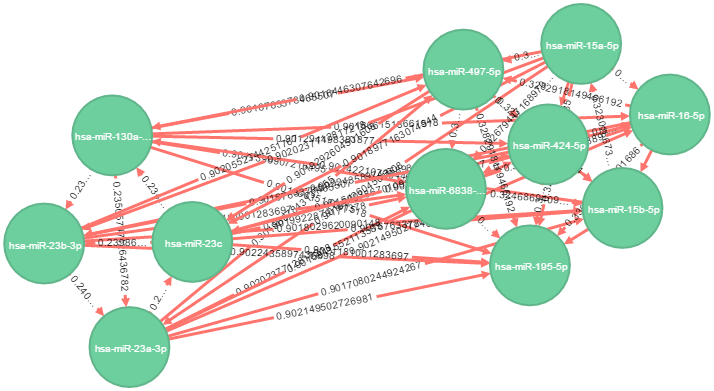

In [1]:
from IPython.display import Image
Image(filename='pictures/subgraph.png') 

The selected subgraph is composed of two visualy distinct clusters of microRNAs based on the Jaccard distances.

##4. Defining a quality metrics for clustering evaluation

In order to use a clustering algorithm, one has to define quantitatively the quality of the clusters found. Accordingly to [Almeida H. 2011](http://link.springer.com/chapter/10.1007%2F978-3-642-23780-5_13), three quality metrics stood out when evaluating very large graphs: *Modularity, coverage and conductance*. Since all three gave similar results, I will use the coverage that is easier to implement:
$$ coverage = \frac{w(C)}{w(G)} $$ 
where
$$ w(C) = \sum_{i=1}^k w(E(v_{x},v_{y}))$$ 
with 
$$ v_{x},v_{y} \in C_{i} $$

The coverage of C (the set of all clusters) is the fraction of weight of all intra cluster edges versus the total weight of all edges in the whole graph G.

In [44]:
graph.schema.create_index(":MIR","NAME")
graph.schema.create_index(":MIR","SUBGRAPH")

In [45]:
whole_graph_edges = graph.cypher.execute('''
    MATCH (mir1:MIR)-[r:TARGET*2]-(mir2:MIR)
    WITH mir1,mir2,COUNT(DISTINCT r) as nb_tar
    WHERE mir1.SUBGRAPH = "YES" AND mir2.SUBGRAPH = "YES"
    RETURN SUM(nb_tar);
''')[0][0]
print("Whole graph edges weight: %d" % whole_graph_edges)

Whole graph edges weight: 179046


In [77]:
#Define the coverage function
def coverage(mir_df):
    edges = 0
    #for each cluster
    for i in range(max(mir_df["cluster"])+1):
        
        #get the list of mir in the current cluster
        list_mir = mir_df.mir[mir_df["cluster"] == i]
        
        #iterate over the list of mir to define pairs
        for mir1 in list_mir:
            for mir2 in list_mir:
                result = graph.cypher.execute('''
                
                MATCH (mir1:MIR {NAME:{mir}})-[r:TARGET*2]-(mir2:MIR {NAME:{col}})
                WITH mir1,mir2, COUNT(DISTINCT r) AS nb_tar
                WHERE mir1.NAME <> mir2.NAME AND mir1.SUBGRAPH = "YES" AND mir2.SUBGRAPH = "YES"
                RETURN SUM(nb_tar)
                
                ''', {"mir":mir1, "col":mir2})[0][0]
                
                edges += result
    return(float(edges)/float(whole_graph_edges))


##5. Clustering of the microRNAs

From the clustering algorithms implemented in sklearn, Affinity propagation do not require to define the number of clusters. This algorithm proceed by sending messages between pair of samples to elect an examplar data point of the cluster. The `preference` parameter influence the number of clusters found. The algorithm could either compute negative euclidian distances or accept precomputed distances (`affinity = "precomputed"`). Here I will use precomputed Jaccard distances.

In [47]:
#Retrieve the pairs of miRs from the subgraph
mir_pairs = graph.cypher.execute('''
    MATCH (mir1:MIR)-[d:DISTANCE]->(mir2:MIR)
    WITH mir1, mir2, d
    WHERE mir1.SUBGRAPH ="YES" AND mir2.SUBGRAPH ="YES"
    RETURN mir1.NAME AS mir1, mir2.NAME AS mir2, d.JACCARD AS distance
''')

In [52]:
print("Number of selected pairs: %d" % len(mir_pairs))

Number of selected pairs: 55


In [51]:
mir_pairs[0]

 mir1           | mir2            | distance      
----------------+-----------------+----------------
 hsa-miR-15b-5p | hsa-miR-130a-5p | 0.901422107304

In [61]:
#First get a list of unique miRs
mir_lst = []
for pair in mir_pairs:
    if pair[0] not in mir_lst:
        mir_lst.append(pair[0])
    if pair[1] not in mir_lst:
        mir_lst.append(pair[1])

#Create a dataframe of miRs for future reference
import pandas as pd
mir_df = pd.DataFrame(mir_lst, columns=["mir"])

#Create a matrix
import numpy as np
len_mat = len(mir_df)
mat = np.empty([len_mat,len_mat], dtype=float)
mat.fill(-100.0)

#Fill the matrix with distance values using the mir ordering found in the mir_df.
#Jaccard distance are multiplied by -100 to comply with the clustering algorithm 
#that usually accepts negative euclidian distances.
for pair in mir_pairs:
    mat[np.where(mir_df.mir == pair[0]), np.where(mir_df == pair[1])] = -100 * pair[2]

#Finally the distance of a mir with itself is 0
np.fill_diagonal(mat,-0.0)

#Show a part of the matrix
mat[:4,:4]

array([[  -0.        ,  -90.14221073, -100.        ,  -32.30286738],
       [ -90.17396907,   -0.        , -100.        , -100.        ],
       [ -90.16763378,  -23.46175963,   -0.        , -100.        ],
       [ -32.67944717,  -90.16446308,  -90.18977163,   -0.        ]])

-100 . . . . . . . . . -90 . . . . . . . . . -80 . . . . . . . . . -70 . . . . . . . . . -60 . . . . . . . . . -50 . . . . . . . . . -40 . . . . . . . . . -30 . . . . . . . . . -20 . . . . . . . . . -10 . . . . . . . . .

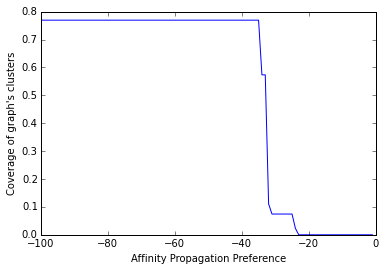

In [78]:
from sklearn.cluster import AffinityPropagation

#values for preference
mat_pref = range(-100, 0,1)

cov_metrics = pd.DataFrame()   
cov=[]
pref=[]
nb_cl=[] 

for i in mat_pref:
    af = AffinityPropagation(preference = i, affinity = "precomputed")
    af.fit(mat)
    
    #get the label of the cluster for each mir
    mir_df["cluster"] = af.labels_
    
    #get the coverage
    cov.append(coverage(mir_df))
    
    #store the preference
    pref.append(i)
    
    #store the number of clusters
    nb_cl.append(len(af.cluster_centers_indices_))
    
    if (i % 10 == 0):
        print i,
    else:
        print ".",
    
#Combine the results into a dataframe
cov_metrics["coverage"] = cov
cov_metrics["preference"] = pref
cov_metrics["nb_clusters"] = nb_cl

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(cov_metrics.preference, cov_metrics.coverage, label=cov_metrics.nb_clusters)
plt.xlabel("Affinity Propagation Preference")
plt.ylabel("Coverage of graph's clusters")
plt.show()

We can observe that any preference values between -100 and -35 produce the best coverage. Thus, as suggested by the affinity propagation documentation we can choose the median of the distance matrix as preference. 

In [79]:
np.median(mat)

-90.205523442517659

In [80]:
cov_metrics[cov_metrics.preference == -90]

,coverage,preference,nb_clusters
10,0.769322,-90,2


The best coverage is for 2 clusters as suggested by visual inspection of the subgraph. 

In [81]:
#expected clusters: - mir130a;23b;23c;23a
#                   - mir6838;195;497;424;15b;16;15a

#Predicted clusters:
af = AffinityPropagation(preference = -90, affinity = "precomputed")
af.fit(mat)

mir_df["cluster"] = af.labels_
mir_df.sort("cluster", inplace=False)

,mir,cluster
1,hsa-miR-130a-5p,0
4,hsa-miR-23a-3p,0
5,hsa-miR-23b-3p,0
0,hsa-miR-15b-5p,1
2,hsa-miR-23c,1
3,hsa-miR-15a-5p,1
6,hsa-miR-16-5p,1
7,hsa-miR-424-5p,1
8,hsa-miR-497-5p,1
9,hsa-miR-6838-5p,1


miR-23c is not in the expected cluster. This may due to the bias observed by [Almeida H. 2011](http://link.springer.com/chapter/10.1007%2F978-3-642-23780-5_13) when using coverage. Indeed the metrics in use favors larger clusters.

###How the partition of miR into clusters changes when using different preference values?

In [85]:
mir_df = pd.DataFrame(mir_lst, columns=["mir"])
mat_pref = range(-100, 0,1)

cov_metrics = pd.DataFrame()   
pref=[]
nb_cl=[] 

for i in mat_pref:
    af = AffinityPropagation(preference = i, affinity = "precomputed")
    af.fit(mat)
    
    #get the label of the cluster for each mir and store them in a new column
    newcol = 'cluster_pref_%d' % i
    mir_df[newcol] = af.labels_
        
    #store the preference
    pref.append(i)
    
    #store the number of clusters
    nb_cl.append(len(af.cluster_centers_indices_))
    
cov_metrics["preference"] = pref
cov_metrics["nb_clusters"] = nb_cl

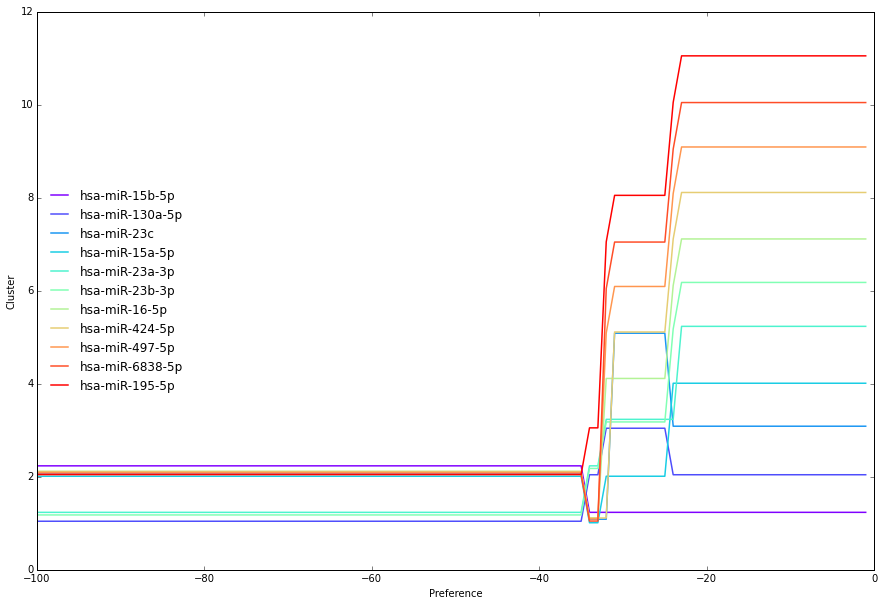

In [123]:
from matplotlib.pyplot import cm
import random
color = iter(cm.rainbow(np.linspace(0,1,11)))
plt.figure(figsize=(15,10))
for i in range(len(mir_df)):
    c=next(color)
    plt.plot(pref,mir_df.iloc[i,1:]+1+0.25*random.random(),  '-', color=c, label=mir_df.iloc[i,0], lw =1.5)

plt.xlabel("Preference")
plt.ylabel("Cluster")
plt.legend(frameon=False, loc='center left')
plt.show()

Members of the clusters do not change with preference changes.Thus, the median of the data seems to be a resonable default preference value for the clustering. Let's look at another subgraph example.

##6. Clustering another subgraph example

In [126]:
ex_mir=["hsa-miR-23a-3p","hsa-miR-23b-3p","hsa-miR-23c","hsa-miR-6838-5p","hsa-miR-16-5p","hsa-miR-195-5p","hsa-miR-15a-5p","hsa-miR-15b-5p","hsa-miR-424-5p","hsa-miR-497-5p","hsa-miR-130a-5p"]

#First de-select the miR from the subgraph
graph.cypher.execute('''
    WITH {N} AS coll
    MATCH (mir1:MIR)
    WHERE mir1.NAME IN coll
    SET mir1.SUBGRAPH ="NO"
    ''', {"N":ex_mir})

In [130]:
#Verify the labels
graph.cypher.execute('''
    WITH {N} AS coll
    MATCH (mir1:MIR)
    WHERE mir1.NAME IN coll
    RETURN mir1.NAME, mir1.SUBGRAPH
''', {"N":ex_mir})

    | mir1.NAME       | mir1.SUBGRAPH
----+-----------------+---------------
  1 | hsa-miR-130a-5p | NO           
  2 | hsa-miR-23a-3p  | NO           
  3 | hsa-miR-23b-3p  | NO           
  4 | hsa-miR-23c     | NO           
  5 | hsa-miR-424-5p  | NO           
  6 | hsa-miR-15a-5p  | NO           
  7 | hsa-miR-497-5p  | NO           
  8 | hsa-miR-16-5p   | NO           
  9 | hsa-miR-195-5p  | NO           
 10 | hsa-miR-6838-5p | NO           
 11 | hsa-miR-15b-5p  | NO           

In [221]:
#Select some random mir closeby miR-28, so they have a chance to be connected
mir = graph.cypher.execute('''
    MATCH (mir1:MIR)-[:TARGET]->()<-[:TARGET]-(mir2:MIR {NAME:"hsa-miR-28-5p"})
    WITH mir1,mir2
    RETURN DISTINCT mir1.NAME LIMIT 20
''')
ex2_mir = []
for i in iter(mir):
    ex2_mir.append(i[0])


In [143]:
#Label the mir as subgraph elements
graph.cypher.execute('''
    WITH {N} AS coll
    MATCH (mir1:MIR)
    WHERE mir1.NAME IN coll
    SET mir1.SUBGRAPH ="YES"
    ''', {"N":ex2_mir})

In [144]:
#Verify the labels
graph.cypher.execute('''
    WITH {N} AS coll
    MATCH (mir1:MIR)
    WHERE mir1.NAME IN coll
    RETURN mir1.NAME, mir1.SUBGRAPH
''', {"N":ex2_mir})

    | mir1.NAME        | mir1.SUBGRAPH
----+------------------+---------------
  1 | hsa-miR-10b-5p   | YES          
  2 | hsa-miR-10a-5p   | YES          
  3 | hsa-miR-106a-5p  | YES          
  4 | hsa-miR-519d-3p  | YES          
  5 | hsa-miR-526b-3p  | YES          
  6 | hsa-miR-93-5p    | YES          
  7 | hsa-miR-3139     | YES          
  8 | hsa-miR-708-5p   | YES          
  9 | hsa-miR-124-3p.1 | YES          
 10 | hsa-miR-506-3p   | YES          
 11 | hsa-miR-124-3p.2 | YES          
 12 | hsa-miR-371a-5p  | YES          
 13 | hsa-miR-340-5p   | YES          
 14 | hsa-miR-101-3p.1 | YES          
 15 | hsa-miR-142-5p   | YES          
 16 | hsa-miR-5590-3p  | YES          
 17 | hsa-miR-224-5p   | YES          
 18 | hsa-miR-1306-5p  | YES          
 19 | hsa-miR-31-5p    | YES          
 20 | hsa-miR-335-5p   | YES          

In [145]:
#Retrieve the pairs of miRs from the subgraph
mir_pairs = graph.cypher.execute('''
    MATCH (mir1:MIR)-[d:DISTANCE]->(mir2:MIR)
    WITH mir1, mir2, d
    WHERE mir1.SUBGRAPH ="YES" AND mir2.SUBGRAPH ="YES"
    RETURN mir1.NAME AS mir1, mir2.NAME AS mir2, d.JACCARD AS distance
''')

In [146]:
print("Number of selected pairs: %d" % len(mir_pairs))

Number of selected pairs: 190


In [162]:
#First get a list of unique miRs
mir_lst = []
for pair in mir_pairs:
    if pair[0] not in mir_lst:
        mir_lst.append(pair[0])
    if pair[1] not in mir_lst:
        mir_lst.append(pair[1])

#Create a dataframe of miRs for future reference
import pandas as pd
mir_df = pd.DataFrame(mir_lst, columns=["mir"])

#Create a matrix
import numpy as np
len_mat = len(mir_df)
mat = np.empty([len_mat,len_mat], dtype=float)
mat.fill(-100.0)

#Fill the matrix with distance values using the mir ordering found in the mir_df.
#Jaccard distance are multiplied by -100 to comply with the clustering algorithms 
#that usually accepts negative euclidian distances.
for pair in mir_pairs:
    mat[np.where(mir_df.mir == pair[0]), np.where(mir_df == pair[1])] = -100 * pair[2]

#Finally the distance of a mir with itself is 0
np.fill_diagonal(mat,-0.0)

#Show a part of the matrix
mat[:4,:4]

array([[  -0.        ,  -94.93333333, -100.        , -100.        ],
       [ -96.97933227,   -0.        , -100.        , -100.        ],
       [ -96.92224622,  -94.9197861 ,   -0.        ,  -91.18060436],
       [ -97.10982659,  -95.56313993, -100.        ,   -0.        ]])

In [163]:
np.median(mat)

-97.73159288687097

-100 . . . . . . . . . -90 . . . . . . . . . -80 . . . . . . . . . -70 . . . . . . . . . -60 . . . . . . . . . -50 . . . . . . . . . -40 . . . . . . . . . -30 . . . . . . . . . -20 . . . . . . . . . -10 . . . . . . . . .

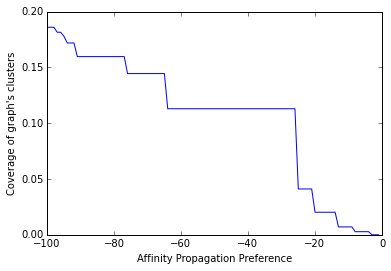

In [164]:
from sklearn.cluster import AffinityPropagation
#values for preference
mat_pref = range(-100, 0,1)

cov_metrics = pd.DataFrame()   
cov=[]
pref=[]
nb_cl=[] 

for i in mat_pref:
    af = AffinityPropagation(preference = i, affinity = "precomputed")
    af.fit(mat)
    
    #get the label of the cluster for each mir
    mir_df["cluster"] = af.labels_
    
    #get the coverage
    cov.append(coverage(mir_df))
    
    #store the preference
    pref.append(i)
    
    #store the number of clusters
    nb_cl.append(len(af.cluster_centers_indices_))
    
    if (i % 10 == 0):
        print i,
    else:
        print ".",
    
#Combine the results into a dataframe
cov_metrics["coverage"] = cov
cov_metrics["preference"] = pref
cov_metrics["nb_clusters"] = nb_cl

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(cov_metrics.preference, cov_metrics.coverage, label=cov_metrics.nb_clusters)
plt.xlabel("Affinity Propagation Preference")
plt.ylabel("Coverage of graph's clusters")
plt.show()

In [165]:
#Predicted clusters:
af = AffinityPropagation(preference = -97, affinity = "precomputed")
af.fit(mat)

mir_df["cluster"] = af.labels_
mir_df.sort("cluster", inplace=False)

,mir,cluster
0,hsa-miR-93-5p,0
16,hsa-miR-31-5p,1
3,hsa-miR-506-3p,1
6,hsa-miR-124-3p.2,1
14,hsa-miR-124-3p.1,1
5,hsa-miR-142-5p,2
8,hsa-miR-5590-3p,2
15,hsa-miR-340-5p,2
11,hsa-miR-224-5p,2
2,hsa-miR-526b-3p,3


In [153]:
mir_df = pd.DataFrame(mir_lst, columns=["mir"])
mat_pref = range(-100, 0,1)

cov_metrics = pd.DataFrame()   
pref=[]
nb_cl=[] 

for i in mat_pref:
    af = AffinityPropagation(preference = i, affinity = "precomputed")
    af.fit(mat)
    
    #get the label of the cluster for each mir
    newcol = 'cluster_pref_%d' % i
    mir_df[newcol] = af.labels_
        
    #store the preference
    pref.append(i)
    
    #store the number of clusters
    nb_cl.append(len(af.cluster_centers_indices_))
    
cov_metrics["preference"] = pref
cov_metrics["nb_clusters"] = nb_cl

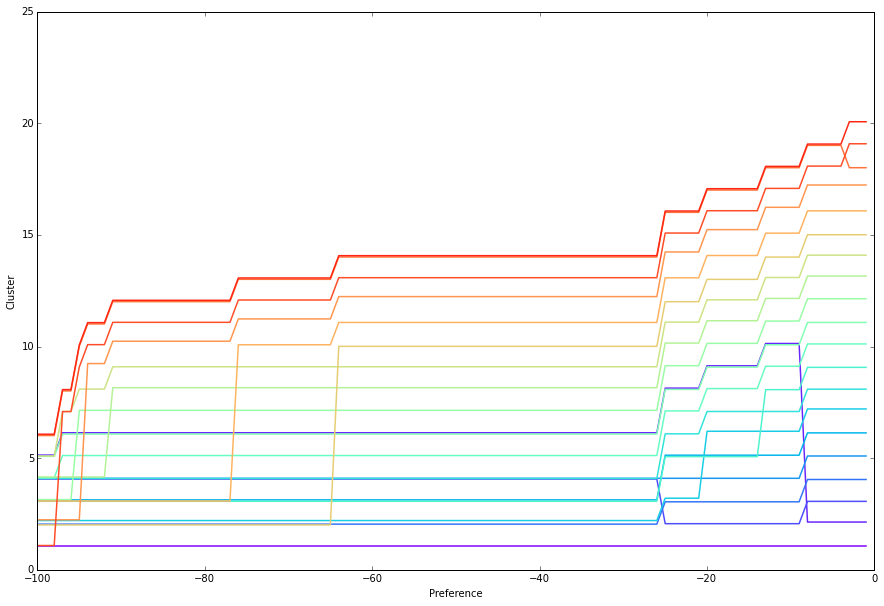

In [158]:
from matplotlib.pyplot import cm
import random
color = iter(cm.rainbow(np.linspace(0,1,21)))
plt.figure(figsize=(15,10))
for i in range(len(mir_df)):
    c=next(color)
    plt.plot(pref,mir_df.iloc[i,1:]+1+0.25*random.random(),  '-', color=c, label=mir_df.iloc[i,0], lw =1.5)

plt.xlabel("Preference")
plt.ylabel("Cluster")
#plt.legend(frameon=False, loc='upper center')
plt.show()

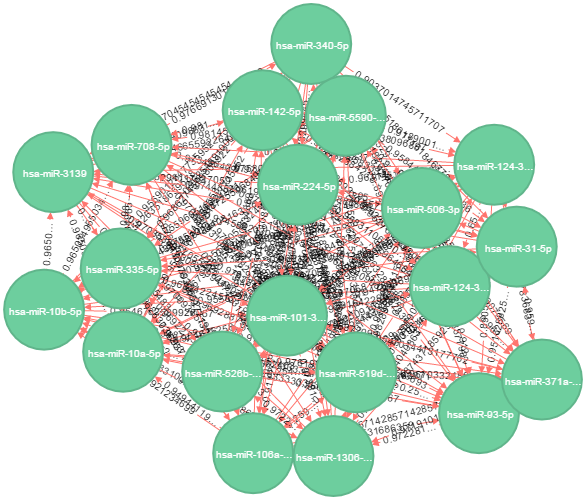

In [2]:
Image(filename='pictures/graph_ex2.png') 

In this second exemple, the clustering by visual inspection is less obvious, thus there is no "expected" clusters. The model with the most stingent condition (`preference = -100`) gives a clustering into 6 groups. Interestingly, microRNAs from the same family are grouped together: miR-124-3p.1 & 3p.2; miR-10a-5p & 10b-5p; miR-3139 & 708-5p. This suggest that microRNAs with the same targets are indeed clustered together properly.

##7. Clustering the whole graph

In [166]:
#Get all the pairs
mir_pairs = graph.cypher.execute('''
    MATCH (mir1:MIR)-[d:DISTANCE]->(mir2:MIR)
    WITH mir1, mir2, d
    RETURN mir1.NAME AS mir1, mir2.NAME AS mir2, d.JACCARD AS distance
''')

In [167]:
print("Number of selected pairs: %d" % len(mir_pairs))

Number of selected pairs: 69472


In [168]:
#Get a list of unique miRs
mir_lst = []
for pair in mir_pairs:
    if pair[0] not in mir_lst:
        mir_lst.append(pair[0])
    if pair[1] not in mir_lst:
        mir_lst.append(pair[1])

#Create a dataframe of miRs for future reference
import pandas as pd
mir_df = pd.DataFrame(mir_lst, columns=["mir"])

#Create a matrix
import numpy as np
len_mat = len(mir_df)
mat = np.empty([len_mat,len_mat], dtype=float)
mat.fill(-100.0)

#Fill the matrix with distance values using the mir ordering found in the mir_df.
#Jaccard distance are multiplied by -100 to comply with the clustering algorithms 
#that usually accepts negative euclidian distances.
for pair in mir_pairs:
    mat[np.where(mir_df.mir == pair[0]), np.where(mir_df == pair[1])] = -100 * pair[2]

#Finally the distance of a mir with itself is 0
np.fill_diagonal(mat,-0.0)

#Show a part of the matrix
mat[:4,:4]

array([[  -0.        ,  -95.90027701,  -96.22991347, -100.        ],
       [ -99.93468321,   -0.        , -100.        , -100.        ],
       [ -99.92486852,  -91.17870722,   -0.        , -100.        ],
       [ -99.89212513,  -91.62257496,  -93.38999056,   -0.        ]])

-100 . . . . . . . . . -90 . . . . . . . . . -80 . . . . . . . . . -70 . . . . . . . . . -60 . . . . . . . . . -50 . . . . . . . . . -40 . . . . . . . . . -30 . . . . . . . . . -20 . . . . . . . . . -10 . . . . . . . . .

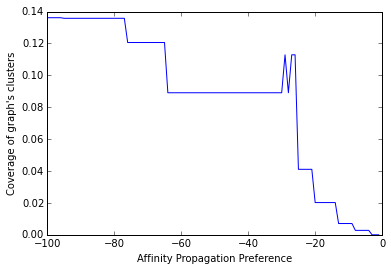

In [185]:
from sklearn.cluster import AffinityPropagation
#values for preference
mat_pref = range(-100, 0,1)

cov_metrics = pd.DataFrame()   
cov=[]
pref=[]
nb_cl=[] 

for i in mat_pref:
    af = AffinityPropagation(preference = i, affinity = "precomputed")
    af.fit(mat)
    
    #get the label of the cluster for each mir
    mir_df["cluster"] = af.labels_
    
    #get the coverage
    cov.append(coverage(mir_df))
    
    #store the preference
    pref.append(i)
    
    #store the number of clusters
    nb_cl.append(len(af.cluster_centers_indices_))
    
    if (i % 10 == 0):
        print i,
    else:
        print ".",
    
#Combine the results into a dataframe
cov_metrics["coverage"] = cov
cov_metrics["preference"] = pref
cov_metrics["nb_clusters"] = nb_cl

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(cov_metrics.preference, cov_metrics.coverage, label=cov_metrics.nb_clusters)
plt.xlabel("Affinity Propagation Preference")
plt.ylabel("Coverage of graph's clusters")
plt.show()

In [186]:
np.median(mat)

-100.0

In [169]:
#Predicted clusters:
af = AffinityPropagation(preference = np.median(mat), affinity = "precomputed")
af.fit(mat)


mir_df["cluster"] = af.labels_


In [170]:
print("Number of clusters: %d" %len(af.cluster_centers_indices_))

Number of clusters: 96


In [184]:
#Add the cluster number as a node property
for cluster in range(len(af.cluster_centers_indices_)):
    mir_names = list(mir_df.ix[mir_df.cluster == cluster,0])
    graph.cypher.execute('''
    WITH {N} AS coll, {C} AS cluster
    MATCH (mir :MIR)
    WHERE mir.NAME IN coll
    SET mir.CLUSTER = cluster
    
    ''', {"N":mir_names, "C":cluster})

##8. Clusters' statistics

In [194]:
#Get the number of miRs per clusters
nb_mir = []
for i in range(96):
    nb_mir.append(graph.cypher.execute('''
    MATCH (mir1 :MIR)
    WHERE mir1.CLUSTER = {n}
    RETURN COUNT(DISTINCT mir1)
    ''', {"n":i})[0][0])

[(3, 26), (4, 21), (2, 19)]


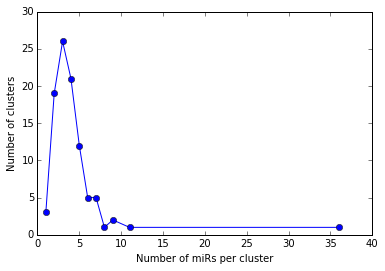

In [206]:
#the frequency counts
import collections
nb_mir.sort()
f = collections.Counter(nb_mir)
print(f.most_common(3))
plt.plot(f.keys(),f.values(), 'o-', color='b')
plt.xlabel("Number of miRs per cluster")
plt.ylabel("Number of clusters")
plt.show()

Interestingly, most clusters are formed of 2 to 5 microRNAs.

What is this large cluster of 36 miRs?

In [217]:
for i in range(96):
    print(graph.cypher.execute('''
        MATCH (mir1:MIR {CLUSTER:{n}})
        RETURN COUNT(DISTINCT mir1) AS Count, {n} AS Cluster
    ''', {"n":i}))

   | Count | Cluster
---+-------+---------
 1 |    36 |       0

   | Count | Cluster
---+-------+---------
 1 |     2 |       1

   | Count | Cluster
---+-------+---------
 1 |     3 |       2

   | Count | Cluster
---+-------+---------
 1 |     2 |       3

   | Count | Cluster
---+-------+---------
 1 |     6 |       4

   | Count | Cluster
---+-------+---------
 1 |     2 |       5

   | Count | Cluster
---+-------+---------
 1 |     1 |       6

   | Count | Cluster
---+-------+---------
 1 |     5 |       7

   | Count | Cluster
---+-------+---------
 1 |     4 |       8

   | Count | Cluster
---+-------+---------
 1 |     3 |       9

   | Count | Cluster
---+-------+---------
 1 |     3 |      10

   | Count | Cluster
---+-------+---------
 1 |     8 |      11

   | Count | Cluster
---+-------+---------
 1 |     6 |      12

   | Count | Cluster
---+-------+---------
 1 |     5 |      13

   | Count | Cluster
---+-------+---------
 1 |     5 |      14

   | Count | Cluster
---+

The cluster of 36 microRNAs is the cluster 0. After examination in Neo4j browser, it is composed of mostly unrelated microRNAs that only have very few targets. It seems to be the default cluster to put the miRs unrelated to any other clusters.

More importantly, the cluster 11 of 8 microRNAs is the family of let7 microRNAs that have very similar sequences and are expected to cluster together.

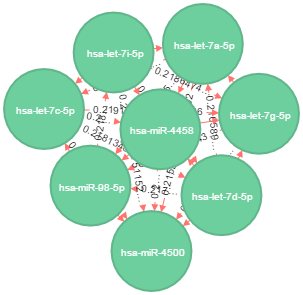

In [3]:
Image(filename="pictures/let7_graph.png")

##9. Conclusion

I showed in this notebook how Neo4j could handle efficiently a very connected graph such as the biological network of microRNAs-mRNA predicted interactions. Here I showed that microRNAs can be clustered accordingly to their common targets. I found 96 clusters (or 95 if we remove the suspicious cluster 0) that are composed mostly of 2 to 5 microRNAs. I used Affinity propagation as the clustering algorithm for this unsupervised task, however other algorithms exist (such as DBSCAN) that could do a clustering without knowing the number of clusters beforehand. These other clustering algorithms need to be tested in regard to the results obtained with the Affinity Propagation algorithm. I could use the metrics implemented here (coverage, part 4) to evaluate the efficiency of each algorithms.